In [1]:
import torch
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms
import torchvision.models as models
from torchvision.datasets import ImageFolder
from torch.utils.data import random_split, DataLoader
from tqdm import tqdm
import numpy as np
from sklearn.metrics import f1_score, accuracy_score
from torchvision.models import efficientnet_b0

In [2]:
from google.colab import drive
drive.mount('/content/drive')

train_dir = "/content/drive/MyDrive/Research paper on cnn and ensemble learning/Dataset/Splitted_dataset/train"
val_dir = "/content/drive/MyDrive/Research paper on cnn and ensemble learning/Dataset/Splitted_dataset/val"
test_dir = "/content/drive/MyDrive/Research paper on cnn and ensemble learning/Dataset/Splitted_dataset/test"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
torch.manual_seed(42)

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [5]:
train_transforms = transforms.Compose([
    transforms.Resize((256, 256)),   ## Resize the images to 256x256
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),   ## Adding random crop to 224x224
    transforms.RandomHorizontalFlip(p=0.5),   ## adding random flips left and right
    transforms.RandomVerticalFlip(p=0.5), ## vertical
transforms.RandomRotation(20),  # ±20 degrees - more realistic variations
transforms.ColorJitter(
    brightness=0.3,   # added more
    contrast=0.3,     # added more
    saturation=0.2,   #
    hue=0.1          #
),
transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
transforms.RandomPerspective(distortion_scale=0.2, p=0.3),
#transforms.RandomErasing(p=0.3, scale=(0.02, 0.15)),
    transforms.ToTensor(),  ## converting the images to tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  ## normalizzing according to resnet34 mean and std values
])

val_test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

])

In [6]:
train_dataset = ImageFolder(root=train_dir, transform=train_transforms)
val_dataset = ImageFolder(root=val_dir, transform=val_test_transforms)
test_dataset = ImageFolder(root=test_dir, transform=val_test_transforms)  ## used val and text transformer for 2 dataset

In [7]:
print(len(train_dataset))

print(len(val_dataset))
print(len(test_dataset))

## 8010 + 998 + 1007 = 1000015

8010
998
1007


In [8]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4)

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [9]:
model = models.efficientnet_b0(pretrained=True)
model = model.to(device)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 20.5M/20.5M [00:00<00:00, 203MB/s]


In [10]:


# Replace classifier
num_features = model.classifier[1].in_features
model.classifier = nn.Sequential(
    nn.Dropout(0.3),
    nn.Linear(num_features, 512),
    nn.BatchNorm1d(512),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(512, 256),
    nn.BatchNorm1d(256),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(256, 7)
)

# training everyting without freezing any steps or layes
model = model.to(device)

In [11]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2.0, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        loss = self.alpha * (1 - pt) ** self.gamma * ce_loss
        return loss.mean() if self.reduction == 'mean' else loss.sum()


In [12]:
from torch.optim.lr_scheduler import ReduceLROnPlateau


criterion = FocalLoss(alpha=0.25, gamma=2.0)

optimizer = optim.Adam(
    model.classifier.parameters(),
    lr=1e-4,
    weight_decay=3e-6
)


scheduler = ReduceLROnPlateau(
    optimizer,
    mode='max',
    patience=3,
    factor=0.5
)

In [13]:
from sklearn.metrics import f1_score
from tqdm import tqdm

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
val_f1_scores = []

epochs = 30
best_f1 = 0.0

for epoch in range(epochs):
    print(f"\nEpoch {epoch + 1}/{epochs}")
    print("-" * 40)
    model.train()

    running_loss = 0.0
    correct = 0
    total = 0

    # ================= TRAINING ==================
    for imgs, labels in tqdm(train_loader, desc="Training"):
        imgs, labels = imgs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / len(train_loader)
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")

    # ================= VALIDATION ==================
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for imgs, labels in tqdm(val_loader, desc="Validating"):
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    val_loss /= len(val_loader)
    val_acc = val_correct / val_total
    val_f1 = f1_score(all_labels, all_preds, average='weighted')

    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    val_f1_scores.append(val_f1)

    print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f} | Val F1: {val_f1:.4f}")

    # Step the LR scheduler based on F1 (since mode='max')
    scheduler.step(val_f1)

    # ================= SAVE BEST MODEL ==================
    if val_f1 > best_f1:
        best_f1 = val_f1
        torch.save(model.state_dict(), "/content/drive/MyDrive/Research paper on cnn and ensemble learning/Models/efficientnet_b0_best(updated).pth")
        print("✅ Model improved and saved!")

print("\n🎯 Training Complete!")
print(f"Best Validation F1-score: {best_f1:.4f}")



Epoch 1/30
----------------------------------------


Training: 100%|██████████| 126/126 [25:46<00:00, 12.28s/it]


Train Loss: 0.2223 | Train Acc: 0.5583


Validating: 100%|██████████| 16/16 [03:33<00:00, 13.37s/it]


Val Loss: 0.1742 | Val Acc: 0.6804 | Val F1: 0.6665
✅ Model improved and saved!

Epoch 2/30
----------------------------------------


Training:   0%|          | 0/126 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 126/126 [02:17<00:00,  1.09s/it]


Train Loss: 0.1512 | Train Acc: 0.6780


Validating: 100%|██████████| 16/16 [00:10<00:00,  1.50it/s]


Val Loss: 0.1345 | Val Acc: 0.7134 | Val F1: 0.6954
✅ Model improved and saved!

Epoch 3/30
----------------------------------------


Training:   0%|          | 0/126 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 126/126 [02:15<00:00,  1.08s/it]


Train Loss: 0.1373 | Train Acc: 0.6863


Validating: 100%|██████████| 16/16 [00:09<00:00,  1.63it/s]


Val Loss: 0.1253 | Val Acc: 0.7114 | Val F1: 0.6978
✅ Model improved and saved!

Epoch 4/30
----------------------------------------


Training:   0%|          | 0/126 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 126/126 [02:16<00:00,  1.08s/it]


Train Loss: 0.1316 | Train Acc: 0.6929


Validating: 100%|██████████| 16/16 [00:11<00:00,  1.45it/s]


Val Loss: 0.1138 | Val Acc: 0.7295 | Val F1: 0.7077
✅ Model improved and saved!

Epoch 5/30
----------------------------------------


Training:   0%|          | 0/126 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 126/126 [02:14<00:00,  1.07s/it]


Train Loss: 0.1276 | Train Acc: 0.6973


Validating: 100%|██████████| 16/16 [00:09<00:00,  1.77it/s]


Val Loss: 0.1071 | Val Acc: 0.7395 | Val F1: 0.7179
✅ Model improved and saved!

Epoch 6/30
----------------------------------------


Training:   0%|          | 0/126 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 126/126 [02:15<00:00,  1.07s/it]


Train Loss: 0.1214 | Train Acc: 0.7020


Validating: 100%|██████████| 16/16 [00:10<00:00,  1.50it/s]


Val Loss: 0.1056 | Val Acc: 0.7465 | Val F1: 0.7398
✅ Model improved and saved!

Epoch 7/30
----------------------------------------


Training:   0%|          | 0/126 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 126/126 [02:14<00:00,  1.07s/it]


Train Loss: 0.1201 | Train Acc: 0.7070


Validating: 100%|██████████| 16/16 [00:10<00:00,  1.60it/s]


Val Loss: 0.1001 | Val Acc: 0.7555 | Val F1: 0.7442
✅ Model improved and saved!

Epoch 8/30
----------------------------------------


Training:   0%|          | 0/126 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 126/126 [02:15<00:00,  1.08s/it]


Train Loss: 0.1162 | Train Acc: 0.7066


Validating: 100%|██████████| 16/16 [00:10<00:00,  1.48it/s]


Val Loss: 0.0986 | Val Acc: 0.7515 | Val F1: 0.7385

Epoch 9/30
----------------------------------------


Training:   0%|          | 0/126 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 126/126 [02:14<00:00,  1.07s/it]


Train Loss: 0.1152 | Train Acc: 0.7102


Validating: 100%|██████████| 16/16 [00:10<00:00,  1.51it/s]


Val Loss: 0.1001 | Val Acc: 0.7435 | Val F1: 0.7394

Epoch 10/30
----------------------------------------


Training:   0%|          | 0/126 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 126/126 [02:14<00:00,  1.07s/it]


Train Loss: 0.1118 | Train Acc: 0.7166


Validating: 100%|██████████| 16/16 [00:09<00:00,  1.73it/s]


Val Loss: 0.0949 | Val Acc: 0.7625 | Val F1: 0.7520
✅ Model improved and saved!

Epoch 11/30
----------------------------------------


Training:   0%|          | 0/126 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 126/126 [02:15<00:00,  1.08s/it]


Train Loss: 0.1101 | Train Acc: 0.7175


Validating: 100%|██████████| 16/16 [00:10<00:00,  1.49it/s]


Val Loss: 0.0961 | Val Acc: 0.7525 | Val F1: 0.7408

Epoch 12/30
----------------------------------------


Training:   0%|          | 0/126 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 126/126 [02:13<00:00,  1.06s/it]


Train Loss: 0.1080 | Train Acc: 0.7166


Validating: 100%|██████████| 16/16 [00:10<00:00,  1.51it/s]


Val Loss: 0.0967 | Val Acc: 0.7395 | Val F1: 0.7315

Epoch 13/30
----------------------------------------


Training:   0%|          | 0/126 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 126/126 [02:15<00:00,  1.08s/it]


Train Loss: 0.1077 | Train Acc: 0.7203


Validating: 100%|██████████| 16/16 [00:09<00:00,  1.62it/s]


Val Loss: 0.0952 | Val Acc: 0.7475 | Val F1: 0.7391

Epoch 14/30
----------------------------------------


Training:   0%|          | 0/126 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 126/126 [02:15<00:00,  1.07s/it]


Train Loss: 0.1082 | Train Acc: 0.7182


Validating: 100%|██████████| 16/16 [00:10<00:00,  1.49it/s]


Val Loss: 0.0930 | Val Acc: 0.7575 | Val F1: 0.7458

Epoch 15/30
----------------------------------------


Training:   0%|          | 0/126 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 126/126 [02:16<00:00,  1.08s/it]


Train Loss: 0.1068 | Train Acc: 0.7210


Validating: 100%|██████████| 16/16 [00:09<00:00,  1.77it/s]


Val Loss: 0.0941 | Val Acc: 0.7505 | Val F1: 0.7409

Epoch 16/30
----------------------------------------


Training:   0%|          | 0/126 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 126/126 [02:15<00:00,  1.07s/it]


Train Loss: 0.1065 | Train Acc: 0.7222


Validating: 100%|██████████| 16/16 [00:10<00:00,  1.47it/s]


Val Loss: 0.0912 | Val Acc: 0.7515 | Val F1: 0.7422

Epoch 17/30
----------------------------------------


Training:   0%|          | 0/126 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 126/126 [02:14<00:00,  1.06s/it]


Train Loss: 0.1048 | Train Acc: 0.7216


Validating: 100%|██████████| 16/16 [00:10<00:00,  1.52it/s]


Val Loss: 0.0947 | Val Acc: 0.7565 | Val F1: 0.7503

Epoch 18/30
----------------------------------------


Training:   0%|          | 0/126 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 126/126 [02:16<00:00,  1.08s/it]


Train Loss: 0.1025 | Train Acc: 0.7263


Validating: 100%|██████████| 16/16 [00:09<00:00,  1.68it/s]


Val Loss: 0.0923 | Val Acc: 0.7565 | Val F1: 0.7472

Epoch 19/30
----------------------------------------


Training:   0%|          | 0/126 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 126/126 [02:16<00:00,  1.08s/it]


Train Loss: 0.1029 | Train Acc: 0.7260


Validating: 100%|██████████| 16/16 [00:10<00:00,  1.51it/s]


Val Loss: 0.0921 | Val Acc: 0.7605 | Val F1: 0.7490

Epoch 20/30
----------------------------------------


Training:   0%|          | 0/126 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 126/126 [02:14<00:00,  1.07s/it]


Train Loss: 0.1036 | Train Acc: 0.7315


Validating: 100%|██████████| 16/16 [00:09<00:00,  1.68it/s]


Val Loss: 0.0925 | Val Acc: 0.7555 | Val F1: 0.7443

Epoch 21/30
----------------------------------------


Training:   0%|          | 0/126 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 126/126 [02:14<00:00,  1.07s/it]


Train Loss: 0.1062 | Train Acc: 0.7237


Validating: 100%|██████████| 16/16 [00:10<00:00,  1.50it/s]


Val Loss: 0.0907 | Val Acc: 0.7635 | Val F1: 0.7515

Epoch 22/30
----------------------------------------


Training:   0%|          | 0/126 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 126/126 [02:13<00:00,  1.06s/it]


Train Loss: 0.1019 | Train Acc: 0.7271


Validating: 100%|██████████| 16/16 [00:10<00:00,  1.53it/s]


Val Loss: 0.0917 | Val Acc: 0.7545 | Val F1: 0.7464

Epoch 23/30
----------------------------------------


Training:   0%|          | 0/126 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 126/126 [02:14<00:00,  1.07s/it]


Train Loss: 0.1042 | Train Acc: 0.7260


Validating: 100%|██████████| 16/16 [00:09<00:00,  1.73it/s]


Val Loss: 0.0897 | Val Acc: 0.7615 | Val F1: 0.7473

Epoch 24/30
----------------------------------------


Training:   0%|          | 0/126 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 126/126 [02:14<00:00,  1.07s/it]


Train Loss: 0.1045 | Train Acc: 0.7298


Validating: 100%|██████████| 16/16 [00:10<00:00,  1.47it/s]


Val Loss: 0.0907 | Val Acc: 0.7645 | Val F1: 0.7525
✅ Model improved and saved!

Epoch 25/30
----------------------------------------


Training:   0%|          | 0/126 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 126/126 [02:13<00:00,  1.06s/it]


Train Loss: 0.1017 | Train Acc: 0.7345


Validating: 100%|██████████| 16/16 [00:10<00:00,  1.51it/s]


Val Loss: 0.0895 | Val Acc: 0.7645 | Val F1: 0.7516

Epoch 26/30
----------------------------------------


Training:   0%|          | 0/126 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 126/126 [02:15<00:00,  1.07s/it]


Train Loss: 0.1025 | Train Acc: 0.7222


Validating: 100%|██████████| 16/16 [00:09<00:00,  1.75it/s]


Val Loss: 0.0927 | Val Acc: 0.7515 | Val F1: 0.7445

Epoch 27/30
----------------------------------------


Training:   0%|          | 0/126 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 126/126 [02:14<00:00,  1.07s/it]


Train Loss: 0.1043 | Train Acc: 0.7243


Validating: 100%|██████████| 16/16 [00:10<00:00,  1.49it/s]


Val Loss: 0.0919 | Val Acc: 0.7625 | Val F1: 0.7544
✅ Model improved and saved!

Epoch 28/30
----------------------------------------


Training:   0%|          | 0/126 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 126/126 [02:14<00:00,  1.07s/it]


Train Loss: 0.1027 | Train Acc: 0.7292


Validating: 100%|██████████| 16/16 [00:10<00:00,  1.50it/s]


Val Loss: 0.0891 | Val Acc: 0.7605 | Val F1: 0.7483

Epoch 29/30
----------------------------------------


Training:   0%|          | 0/126 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 126/126 [02:16<00:00,  1.09s/it]


Train Loss: 0.1037 | Train Acc: 0.7250


Validating: 100%|██████████| 16/16 [00:10<00:00,  1.52it/s]


Val Loss: 0.0906 | Val Acc: 0.7595 | Val F1: 0.7479

Epoch 30/30
----------------------------------------


Training:   0%|          | 0/126 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 126/126 [02:17<00:00,  1.09s/it]


Train Loss: 0.1019 | Train Acc: 0.7308


Validating: 100%|██████████| 16/16 [00:10<00:00,  1.51it/s]

Val Loss: 0.0913 | Val Acc: 0.7565 | Val F1: 0.7471

🎯 Training Complete!
Best Validation F1-score: 0.7544


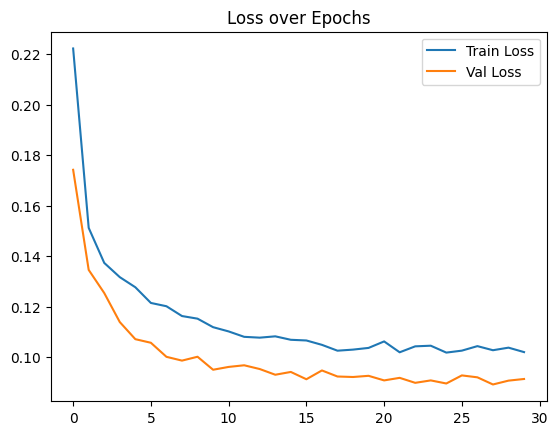

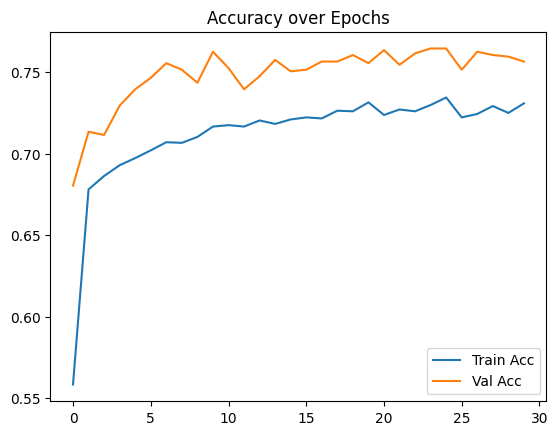

In [14]:
import matplotlib.pyplot as plt

plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.legend()
plt.title('Loss over Epochs')
plt.show()

plt.plot(train_accuracies, label='Train Acc')
plt.plot(val_accuracies, label='Val Acc')
plt.legend()
plt.title('Accuracy over Epochs')
plt.show()

In [15]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
import json
import numpy as np

# ==============================
# 1️⃣ Load Best Model
# ==============================
model.load_state_dict(torch.load("/content/drive/MyDrive/Research paper on cnn and ensemble learning/Models/efficientnet_b0_best(updated).pth", map_location=device))
model.eval()

# ==============================
# 2️⃣ Evaluate on Test Set
# ==============================
all_preds, all_labels = [], []

with torch.no_grad():
    for imgs, labels in tqdm(test_loader, desc="Testing"):
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        preds = torch.argmax(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# ==============================
# 3️⃣ Compute Metrics
# ==============================
test_acc = accuracy_score(all_labels, all_preds)
test_f1 = f1_score(all_labels, all_preds, average='weighted')
cm = confusion_matrix(all_labels, all_preds)

print(f"\n📊 Test Accuracy: {test_acc:.4f}")
print(f"📈 Test F1-score: {test_f1:.4f}")
print("\nClassification Report:")
print(classification_report(all_labels, all_preds))

# ==============================
# 4️⃣ Save Metrics for Ensemble Weighting
# ==============================
metrics = {
    "model": "efficientnet_b0(updated)",
    "test_accuracy": float(test_acc),
    "test_f1": float(test_f1)
}

with open("/content/drive/MyDrive/Research paper on cnn and ensemble learning/Results/metrics_efficientnet_b0(updated).json", "w") as f:
    json.dump(metrics, f, indent=4)

print("\n✅ Metrics saved to metrics_efficientnet_b0(updated).json")


Testing:   0%|          | 0/16 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Testing: 100%|██████████| 16/16 [03:32<00:00, 13.29s/it]


📊 Test Accuracy: 0.7557
📈 Test F1-score: 0.7508

Classification Report:
              precision    recall  f1-score   support

           0       0.43      0.47      0.45        34
           1       0.54      0.65      0.59        52
           2       0.44      0.58      0.50       111
           3       0.00      0.00      0.00        12
           4       0.51      0.35      0.41       112
           5       0.89      0.89      0.89       671
           6       0.82      0.60      0.69        15

    accuracy                           0.76      1007
   macro avg       0.52      0.51      0.51      1007
weighted avg       0.75      0.76      0.75      1007


✅ Metrics saved to metrics_efficientnet_b0(updated).json



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [16]:
import json
metrics = [
    json.load(open("metrics_resnet34.json")),
    json.load(open("metrics_resnet50.json")),
    json.load(open("metrics_efficientnet_b0.json")),
]

FileNotFoundError: [Errno 2] No such file or directory: 'metrics_resnet34.json'